In [478]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

import random
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.compiler import transpile, assemble

# <mark>Dataset</mark>
---

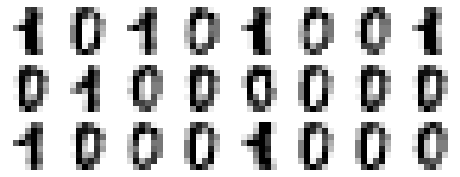

In [459]:
digits = datasets.load_digits(n_class=2)

rows = 3
cols = 8
fig, axs = plt.subplots(rows, cols, figsize=(8,3))

for i in range(rows):
    for j in range(cols):
        axs[i,j].set_axis_off()
        axs[i,j].imshow(digits.images[random.randint(0,9)], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

## Data Preprocessing
---

In [460]:
def print_dataset(title, sample_test, sample_train):
    
    fig, axs = plt.subplots(1, 1, figsize=(8,3))
    plt.hist(np.concatenate(sample_test))
    plt.title(f"""
    {title}
    TEST: {sample_test.shape} - max: {sample_test.max():0.2f}, min:{sample_test.min():0.2f}
    TRAIN:{sample_train.shape} - max: {sample_train.max():0.2f}, min:{sample_train.min():0.2f}
    """)
    plt.show()
    

In [461]:
sample_train, sample_test, label_train, label_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)


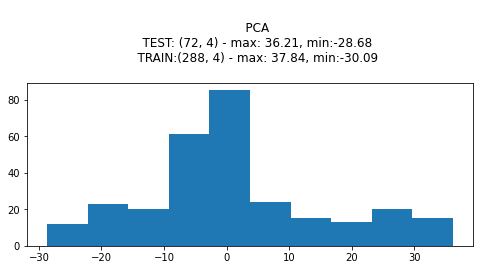

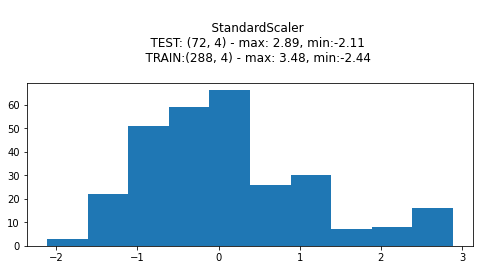

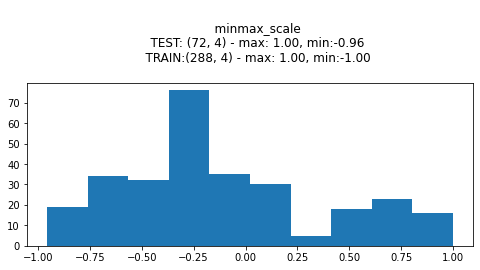

In [462]:

n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

print_dataset('PCA', sample_test, sample_train)

std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

print_dataset('StandardScaler', sample_test, sample_train)

samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

train_size = 500
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 100
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

print_dataset('minmax_scale', sample_test, sample_train)


# <mark>Data Encoding</mark>
---

### Quantum Feature Maps
---
I want to implement a feature map similar to the one defined below:


$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, X_j\right) \, H^{\otimes n} \right)^d.$$ 

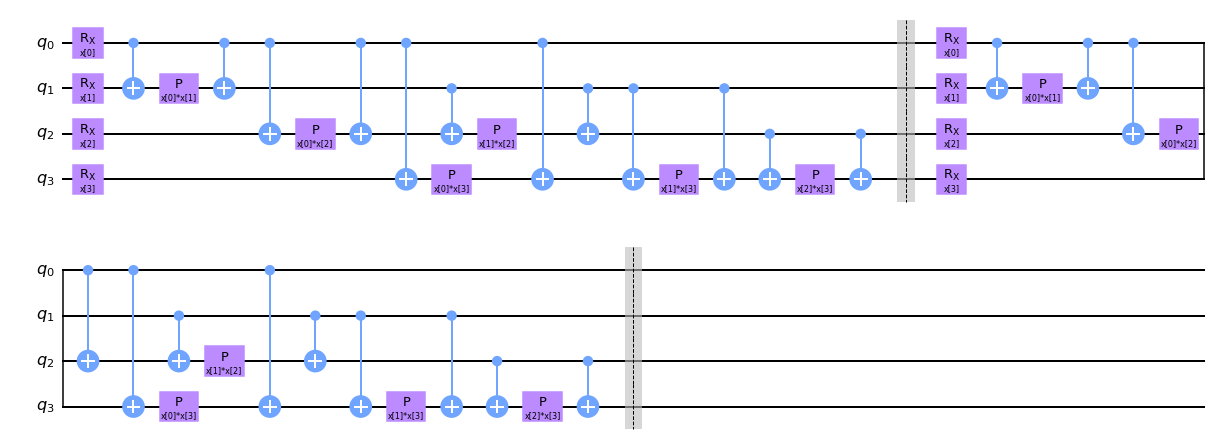

In [463]:
qubits = 4     
repeats = 2

x = ParameterVector('x', length=qubits)
var_custom = QuantumCircuit(qubits)

for _ in range(repeats):
    for i in range(qubits):
        var_custom.rx(x[i], i)
    for i in range(qubits):
        for j in range(i + 1, qubits):
            var_custom.cx(i, j)
            var_custom.p(x[i] * x[j], j)
            var_custom.cx(i, j)
    var_custom.barrier()
            
var_custom.draw('mpl')

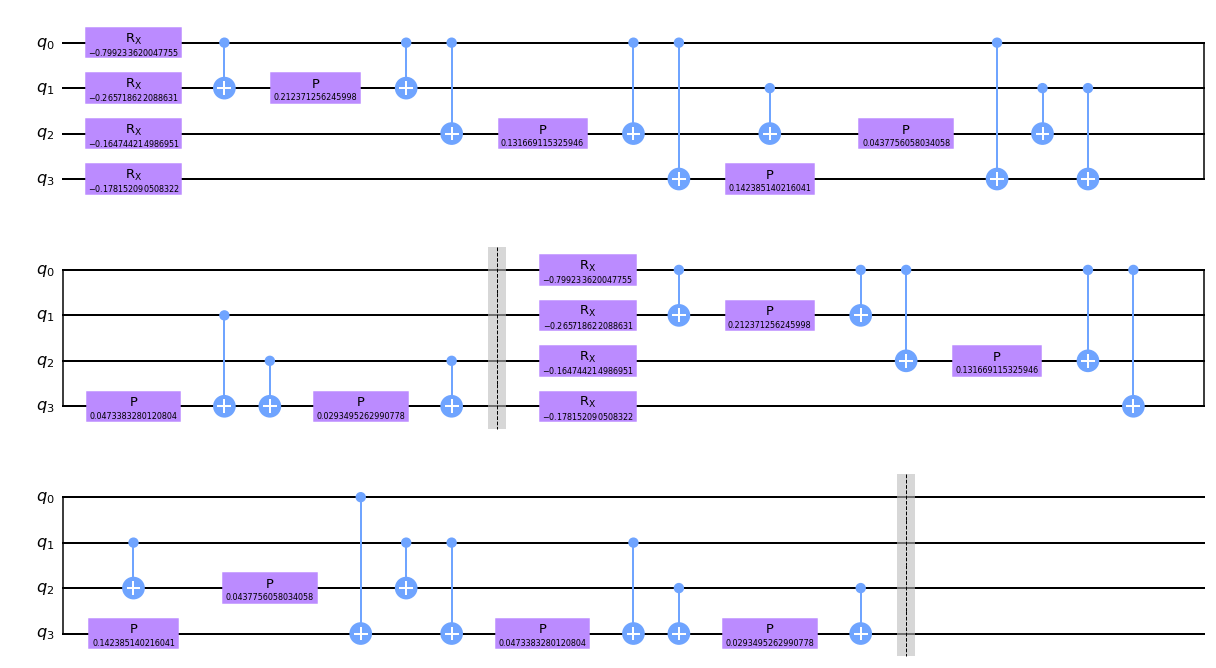

In [464]:
encode_circuit = var_custom.bind_parameters(sample_train[0])
encode_circuit.draw(output='mpl')

# <mark>Quantum Kernel Estimation</mark>
---

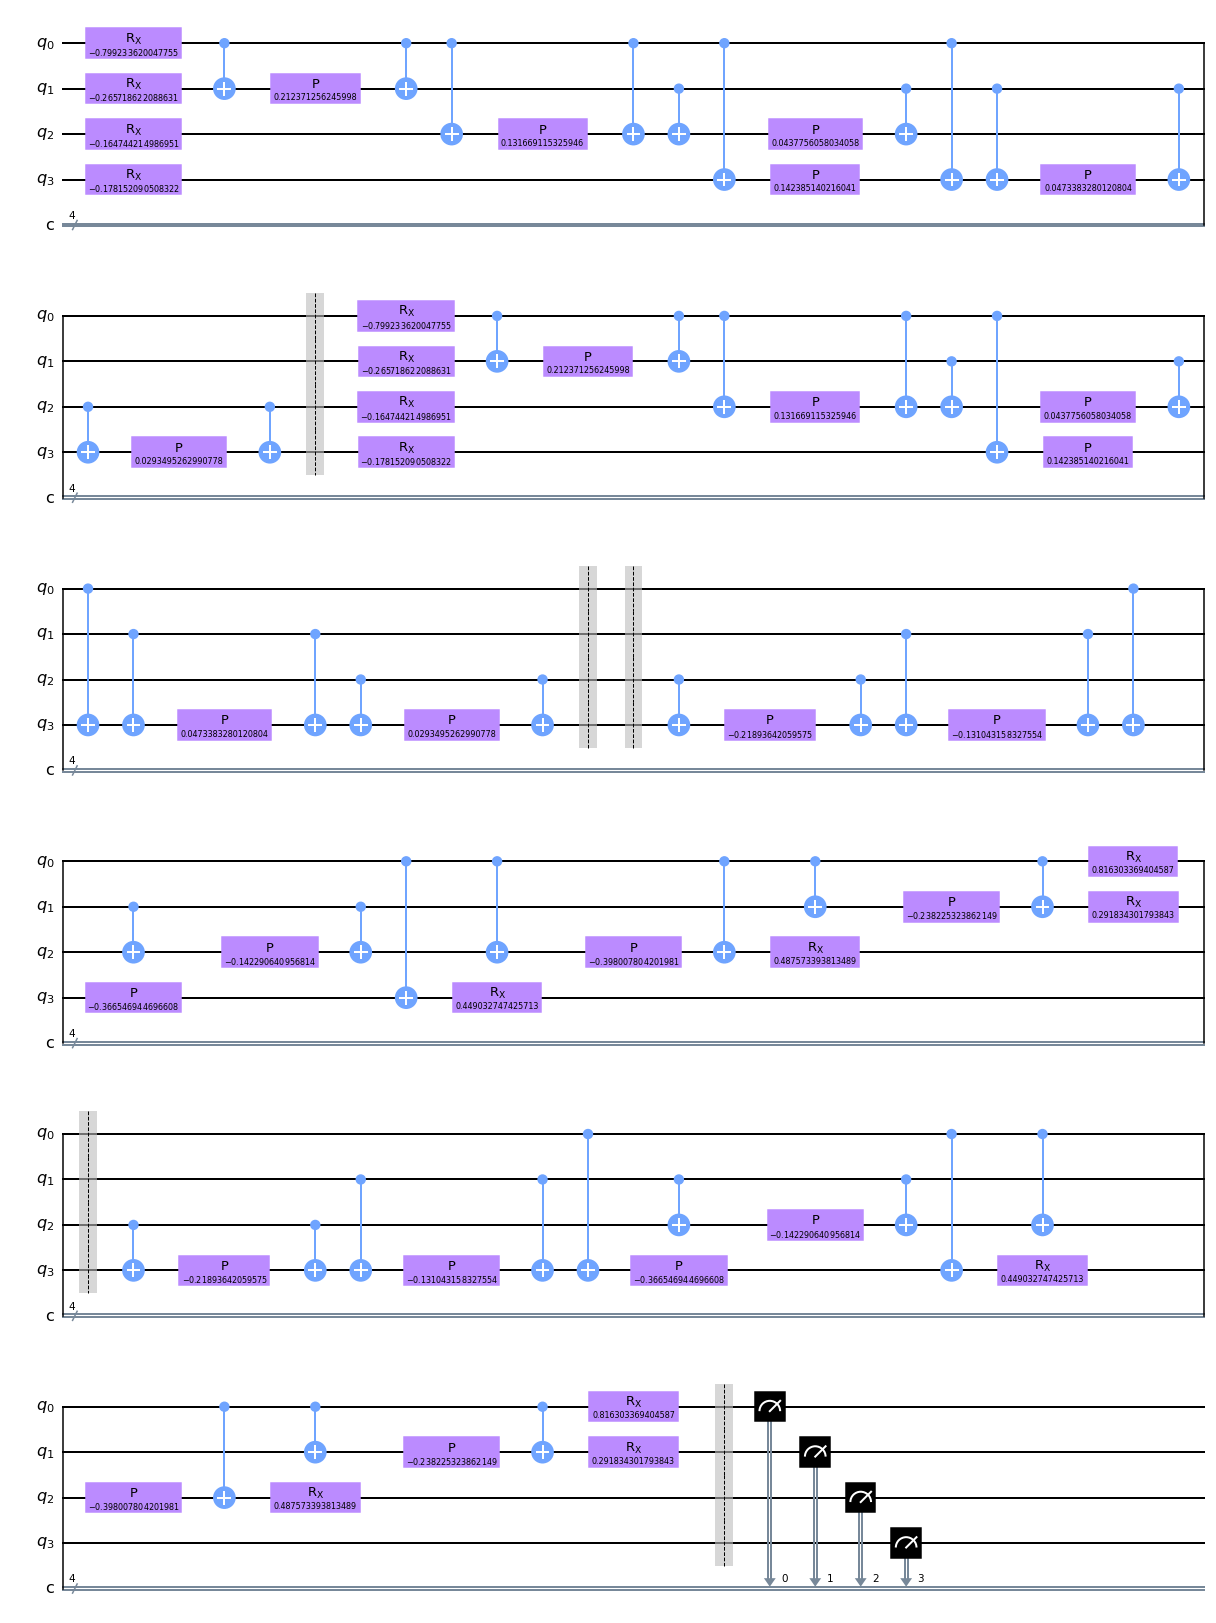

In [466]:
zz_kernel = QuantumKernel(feature_map=var_custom, quantum_instance=Aer.get_backend('statevector_simulator'))

zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
# zz_circuit.decompose().decompose().draw(output='mpl')
zz_circuit.decompose().draw(output='mpl')

In [467]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, seed_simulator=1024, seed_transpiler=1024)

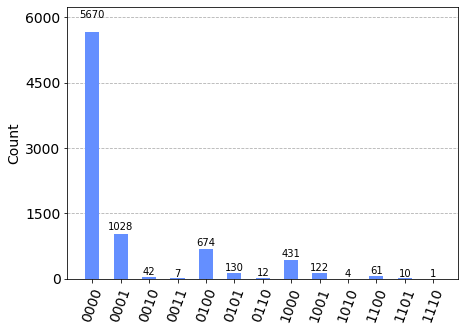

In [468]:
# Get the results of the computation
results = job.result()
counts = results.get_counts()

plot_histogram(counts)

The transition amplitude is the proportion of counts in the zero state:

# <mark>Result</mark>
---

## kernel Matrices
---

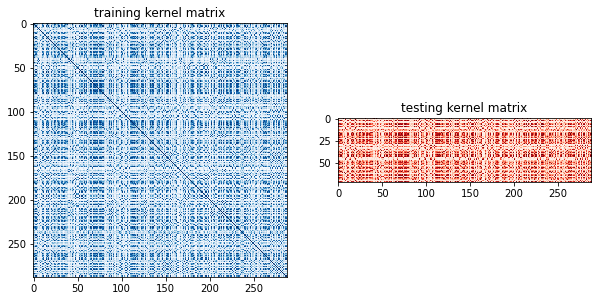

In [470]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

## SVC by Quantum Kernel
---

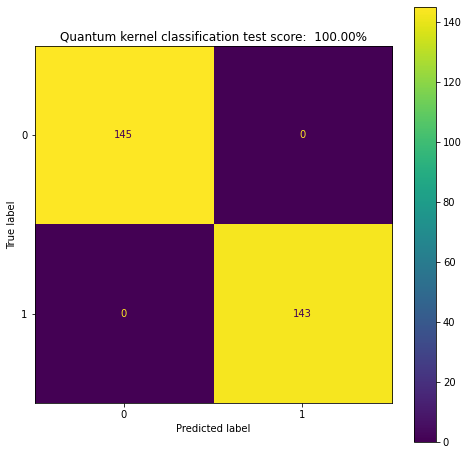

In [471]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f'Quantum kernel classification test score:  {zzcb_score*100:0.2f}%')
plot_confusion_matrix(zzcb_svc, sample_train, label_train, ax=ax)


## SVC by Classical Kernels
---

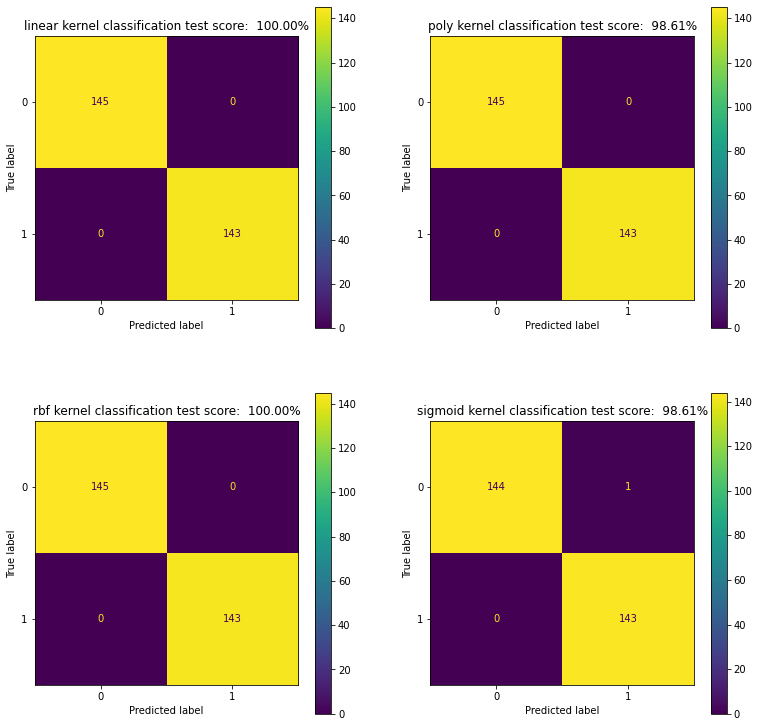

In [472]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
i = 0
fig = plt.figure(figsize=(13, 13))
for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)
    
    ax = fig.add_subplot(2, 2, i + 1)
    i+=1
    ax.set_title(f'{kernel} kernel classification test score:  {classical_score*100:0.2f}%')
    plot_confusion_matrix(classical_svc, sample_train, label_train, ax=ax)

plt.show()

# Run on IBMQ

In [473]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n_dim+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2022-12-28 00:55:05,757: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_quito


In [474]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(zz_circuit, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


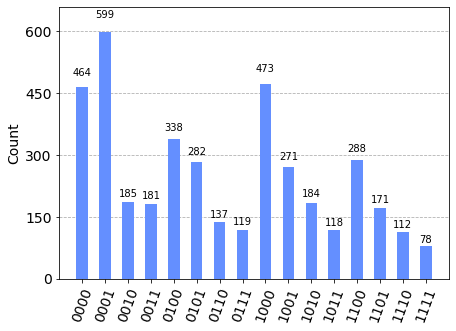

In [475]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

In [476]:
zz_ibmq_kernel = QuantumKernel(feature_map=var_custom, quantum_instance=backend)

In [477]:
zzcb_svc = SVC(kernel=zz_ibmq_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

print(f'Quantum kernel classification test score:  {zzcb_score*100:0.2f}%')
plot_confusion_matrix(zzcb_svc, sample_train, label_train);



CircuitError: 'Bound parameter expression is complex in gate rz'